## Packages

In [1]:
cd("../../../")

using Pkg

Pkg.activate(".")
# Pkg.update("StLifeIns")
Pkg.instantiate()
Pkg.precompile()

  Activating project at `C:\Users\User-PC\PythonProjects\Tricycle\StLifeIns`


In [2]:
using StLifeIns
setGPU()
setMAX_AGE(103); setYEAR_MON(2019)

print("MAX_AGE = ", MAX_AGE, "\n")
print("YEAR_MON = ", YEAR_MON)

MAX_AGE = 103
YEAR_MON = 2019

In [3]:
include(joinpath(@__DIR__, "src\\mortality_models\\ReadMortalityModels.jl")); using .ReadMortalityModels
include(joinpath(@__DIR__, "src\\interest_inflation\\interest\\ReadInterestModels.jl")); using .ReadInterestModels
include(joinpath(@__DIR__, "src\\interest_inflation\\inflation\\ReadInflationModels.jl")); using .ReadInflationModels
include(joinpath(@__DIR__, "src\\model_combo.jl"))

forecast_int_infl (generic function with 1 method)

In [4]:
using Setfield: @set

In [5]:
using Plots

## Endowment Assurance

### Life

In [6]:
# id, female, age=47+5/12, term = 25 years, term in force = 0 months
life = TermLife(0101010, false, 47+5/12, 25*12, 0)

TermLife(101010, false, 47.416666666666664, 300, 0, 103, 300)

### Cashflows

In [7]:
# level monthly premiums of 100 in advance, applicable from the first month
premiums = [RecurringCashflow("prem", 100, 0, 1, 12, false, InForce())]

1-element Vector{RecurringCashflow}:
 RecurringCashflow("prem", 100.0, 0.0, 1, 12, false, InForce())

In [8]:
# benefit of 50000 on death or survival to term, payable in arrears
benefits = [AnyTimeCashflow("deathben", -50000, 0, true, OnDeath()),
            PointCashflow("survben", -50000, life.proj_max, true, InForce())]


2-element Vector{Cashflow}:
 AnyTimeCashflow("deathben", -50000.0, 0.0, true, OnDeath())
 PointCashflow("survben", -50000.0, 300, true, InForce())

In [9]:
# level monthly expenses of 10 in arrears, applicable from the first month
# claim expenses of 200 on death or survival to term in arrears
# termination of contract expense of 100 in arrears
expenses = [RecurringCashflow("regexp", -10, 0, 1, 12, true, InForce()),
            AnyTimeCashflow("deathexp", -200, 0, true, OnDeath()),
            PointCashflow("survexp", -200, life.proj_max, true, InForce()),
            AnyTimeCashflow("termexp", -100, 0, true, OnTermination())]

4-element Vector{Cashflow}:
 RecurringCashflow("regexp", -10.0, 0.0, 1, 12, true, InForce())
 AnyTimeCashflow("deathexp", -200.0, 0.0, true, OnDeath())
 PointCashflow("survexp", -200.0, 300, true, InForce())
 AnyTimeCashflow("termexp", -100.0, 0.0, true, OnTermination())

In [10]:
penalties = []

Any[]

### Policy

In [11]:
policy = StandardPolicy("ea", life, premiums, benefits, expenses, penalties)

StandardPolicy("ea", TermLife(101010, false, 47.416666666666664, 300, 0, 103, 300), Cashflow[RecurringCashflow("prem", 100.0, 0.0, 1, 12, false, InForce())], Cashflow[AnyTimeCashflow("deathben", -50000.0, 0.0, true, OnDeath()), PointCashflow("survben", -50000.0, 300, true, InForce())], Cashflow[RecurringCashflow("regexp", -10.0, 0.0, 1, 12, true, InForce()), AnyTimeCashflow("deathexp", -200.0, 0.0, true, OnDeath()), PointCashflow("survexp", -200.0, 300, true, InForce()), AnyTimeCashflow("termexp", -100.0, 0.0, true, OnTermination())], Cashflow[])

## Basis

In [12]:
nsims = 10000 # number of simulations
max_proj = life.proj_max # since only one policy
max_term = 12*103 # 103 is the maximum age

1236

#### Mortality

In [13]:
mortmodel = mortmodel_dict["Lee-Carter Negative Binomial"]

Dict{Bool, GAPC} with 2 entries:
  0 => LeeCarter(19:103, 1950:2018, [-7.98257, -7.98352, -7.94439, -7.93947, -7…
  1 => LeeCarter(19:103, 1950:2018, [-7.07363, -7.04496, -7.05496, -7.06141, -7…

In [14]:
# simulates mortality for every age, male and female
mortality = simulate_mortality(mortmodel, nsims)

Dict{Bool, OrderedCollections.OrderedDict{Int8, Matrix{Float64}}} with 2 entries:
  0 => OrderedCollections.OrderedDict(19=>[1.74358e-5; 1.76713e-5; … ; 1.75589e…
  1 => OrderedCollections.OrderedDict(19=>[4.2383e-5; 3.80998e-5; … ; 3.62937e-…

#### Interest and Inflation

In [15]:
intmodel = intmodel_dict["CIR"]
inflmodel = inflmodel_dict["Regression with Arima Errors 1"]

RegWithArimaErrors1(["infl.l1", "int.l0", "int.l1"], [0.28748015449368014, 4.2718047549737, -3.8432848466863465], [0.006040805761017907, 0.002759492697221169, -4.76188475478156e-5, -0.0014399953073214694, -0.0004329273410322281, -0.0003525596501035531, -0.0006344929027054068, -0.0019458778070725157, -0.0034022772158820245, -0.0022996715245049695, -0.0013271050819798503, -0.0012171964476822004], 0.8904042514335486, -0.5390078507024059, 0.002539590815255443, [0.0021260066195946522, 0.0019086736294481252, -0.0009363564951983013, 0.0001093592310431279, 0.0003967639239846428, -0.00173439302524579, 0.002946608583641831, -0.0023887633310224424, -0.0029985414320851237, -3.94267878607775e-5, 0.000888811127409229, -0.0002166704631360038])

In [16]:
# simulates monthly effective interest and inflation from starting values
int, infl = simulate_int_infl(int_start, intmodel,
                              infl_start, inflmodel,
                              nsims, max_proj, 1/12)

([0.00689469328673975 0.007362943252695153 … 0.007244614390748971 0.007160592836326973; 0.008551456866751739 0.007343384199166358 … 0.0064134220818541365 0.006402966800931553; … ; 0.007254766744881902 0.006866727464624356 … 0.0065971080283415695 0.00675652130606208; 0.008189435798882538 0.007221758737896655 … 0.007169971512407836 0.006134482248820294], [0.0020888088819234992 0.0052882513494467934 … -0.0002385257497032698 0.0017929143759743168; 0.015354810767196095 0.00028337272130001586 … 0.0046222489411622564 0.002325179050678618; … ; 0.009058245417203521 -0.00030460878845472387 … 0.00284510633863731 0.0038117769547605664; 0.013433739576666725 0.0011344160349293498 … 0.004463699243011968 0.004498672099895667])

#### Surrender Rates

In [17]:
# yearly probability of surrender and number of months for which applicable
surr_ea = [0.05 => 12, 0.04 => 12, 0.03 => 12, 0.02 => 12, 0.01 => Inf]
surr_ea = create_surrender_rates(surr_ea, nsims, max_term)

10000×1236 Matrix{Float64}:
 0.00427444  0.00427444  0.00427444  0.00427444  …  0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444  …  0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444  …  0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444     0.000837528  0.000837528
 0.00427444  0.00427444  0.00427444  0.00427444 

## Reserves

In [18]:
resbasis = StProductBasis(nsims, max_proj, 1.05*mortality, surr_ea, int, infl)

StProductBasis(10000, 300, Dict{Bool, OrderedCollections.OrderedDict{Int8, CUDA.CuArray{Float32, 2}}}(0 => OrderedCollections.OrderedDict(19 => Float32[1.8307617f-5; 1.8554812f-5; … ; 1.8436893f-5; 1.6972643f-5;;], 20 => Float32[1.7752325f-5 1.6368049f-5; 1.8006742f-5 1.8018063f-5; … ; 1.788535f-5 2.3096844f-5; 1.6382044f-5 1.6503936f-5], 21 => Float32[1.8213272f-5 1.675765f-5 1.9144347f-5; 1.8481129f-5 1.849305f-5 1.6043616f-5; … ; 1.8353312f-5 2.3859233f-5 3.030326f-5; 1.6772352f-5 1.6900405f-5 1.4245274f-5], 22 => Float32[1.7817976f-5 1.6325246f-5 1.8775978f-5 1.7875462f-5; 1.8093333f-5 1.8105593f-5 1.5595362f-5 1.8648117f-5; … ; 1.7961913f-5 2.3661327f-5 3.0416328f-5 3.4802983f-5; 1.6340291f-5 1.647136f-5 1.3764517f-5 1.2468694f-5], 23 => Float32[1.82866f-5 1.6730364f-5 … 1.8346576f-5 2.0570322f-5; 1.8573914f-5 1.8586708f-5 … 1.9153007f-5 1.7207627f-5; … ; 1.8436778f-5 2.4397914f-5 … 3.6116355f-5 3.4982826f-5; 1.6746037f-5 1.6882594f-5 … 1.2721234f-5 1.0855188f-5], 24 => Float32[1.

In [19]:
res_calc = reserves(policy, resbasis)

StochasticReserveCalcs(StandardPolicy("ea", TermLife(101010, false, 47.416666666666664, 300, 0, 103, 300), Cashflow[RecurringCashflow("prem", 100.0, 0.0, 1, 12, false, InForce())], Cashflow[AnyTimeCashflow("deathben", -50000.0, 0.0, true, OnDeath()), PointCashflow("survben", -50000.0, 300, true, InForce())], Cashflow[RecurringCashflow("regexp", -10.0, 0.0, 1, 12, true, InForce()), AnyTimeCashflow("deathexp", -200.0, 0.0, true, OnDeath()), PointCashflow("survexp", -200.0, 300, true, InForce()), AnyTimeCashflow("termexp", -100.0, 0.0, true, OnTermination())], Cashflow[]), PolicyBasis(10000, 300, false, Float32[0.00013849999 0.00013849999 … 0.0014838635 0.0014838635; 0.0001403329 0.0001403329 … 0.0010599674 0.0010599674; … ; 0.0001394586 0.0001394586 … 0.00212933 0.00212933; 0.00012859282 0.00012859282 … 0.0011608853 0.0011608853], Float32[0.0042744414 0.0042744414 … 0.000837528 0.000837528; 0.0042744414 0.0042744414 … 0.000837528 0.000837528; … ; 0.0042744414 0.0042744414 … 0.000837528 0

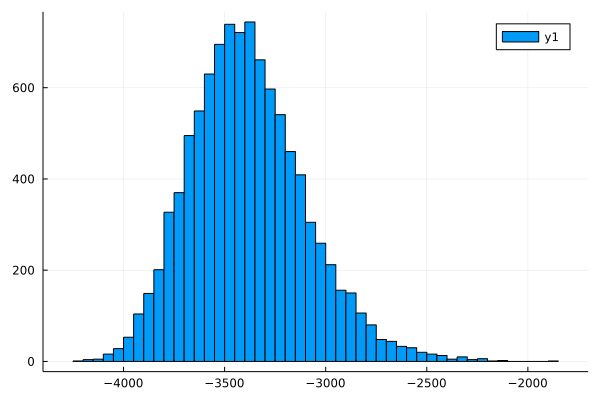

In [20]:
res1 = res_calc.reserves[:, 1]
res1 = convert(Vector{Float64}, res1)

histogram(1:nsims, res1)

In [21]:
res_calc2 = simulate_loss(policy, resbasis)

SimulatedLossFunding(StandardPolicy("ea", TermLife(101010, false, 47.416666666666664, 300, 0, 103, 300), Cashflow[RecurringCashflow("prem", 100.0, 0.0, 1, 12, false, InForce())], Cashflow[AnyTimeCashflow("deathben", -50000.0, 0.0, true, OnDeath()), PointCashflow("survben", -50000.0, 300, true, InForce())], Cashflow[RecurringCashflow("regexp", -10.0, 0.0, 1, 12, true, InForce()), AnyTimeCashflow("deathexp", -200.0, 0.0, true, OnDeath()), PointCashflow("survexp", -200.0, 300, true, InForce()), AnyTimeCashflow("termexp", -100.0, 0.0, true, OnTermination())], Cashflow[]), PolicyBasis(10000, 300, false, Float32[0.00013849999 0.00013849999 … 0.0014838635 0.0014838635; 0.0001403329 0.0001403329 … 0.0010599674 0.0010599674; … ; 0.0001394586 0.0001394586 … 0.00212933 0.00212933; 0.00012859282 0.00012859282 … 0.0011608853 0.0011608853], Float32[0.0042744414 0.0042744414 … 0.000837528 0.000837528; 0.0042744414 0.0042744414 … 0.000837528 0.000837528; … ; 0.0042744414 0.0042744414 … 0.000837528 0.0

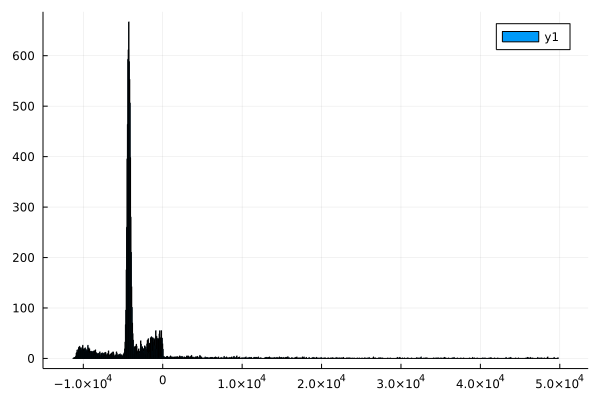

In [22]:
res2 = res_calc2.funding_levels[:, 1]
res2 = convert(Vector{Float64}, res2)

histogram(1:nsims, res2)

## Profit

In [23]:
profbasis = StProductBasis(nsims, max_proj, mortality, Float32(1.02)*surr_ea, int, infl)
rdr = 0.1 # 10% risk discount rate
policy = @set policy.expenses = 0.9*policy.expenses

# crudely using the reserves under the first simulation
res = res_calc.reserves[1, :]

300-element CUDA.CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -3096.880061120507
 -3048.3067148717255
 -3000.624202500392
 -2952.1186487220048
 -2899.38930882737
 -2847.2841357518505
 -2794.67482912399
 -2741.756584211095
 -2687.635455974591
 -2636.032224732565
 -2583.6455003346978
 -2530.3166460314674
 -2478.6318233303273
     ⋮
 45792.913980281104
 46184.02451849535
 46543.492409137594
 46941.56726683164
 47321.78839293846
 47696.83772422835
 48105.9834800077
 48523.415600152985
 48969.161137572766
 49420.12097953763
 49883.860149880624
 50346.74726907051

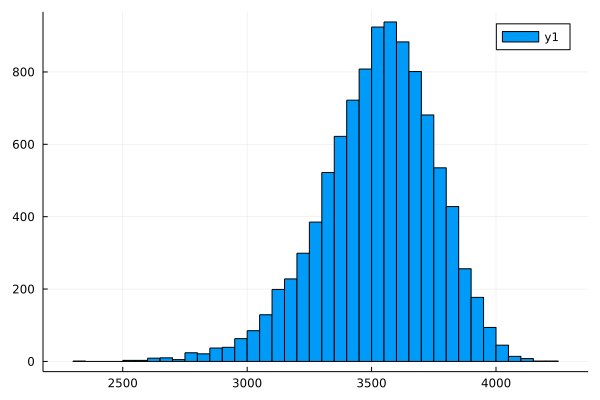

In [24]:
# stochastic-basis approach
prof = profit(policy, profbasis, res, rdr)
prof = convert(Vector{Float64}, prof)

histogram(1:nsims, prof)

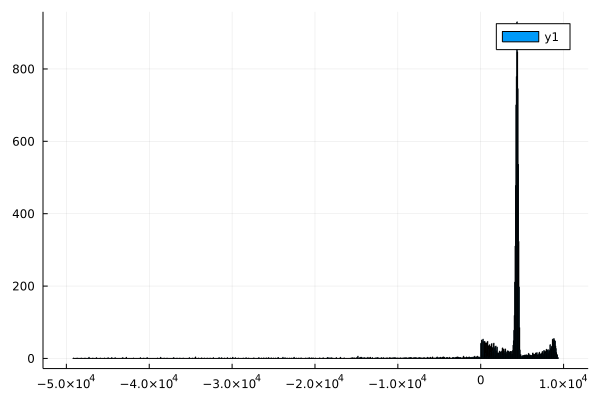

In [25]:
# simulate-lives approach
prof2 = simulate_profit(policy, profbasis, res, rdr)
prof2 = convert(Vector{Float64}, prof2)

histogram(1:nsims, prof2)

## Price

In [26]:
# level monthly premiums of 1 in advance, applicable from the first month
premiums = [RecurringCashflow("prem", 1, 0, 1, 12, false, InForce())]
policy = @set policy.premiums = premiums

StandardPolicy("ea", TermLife(101010, false, 47.416666666666664, 300, 0, 103, 300), Cashflow[RecurringCashflow("prem", 1.0, 0.0, 1, 12, false, InForce())], Cashflow[AnyTimeCashflow("deathben", -50000.0, 0.0, true, OnDeath()), PointCashflow("survben", -50000.0, 300, true, InForce())], Cashflow[RecurringCashflow("regexp", -9.0, 0.0, 1, 12, true, InForce()), AnyTimeCashflow("deathexp", -180.0, 0.0, true, OnDeath()), PointCashflow("survexp", -180.0, 300, true, InForce()), AnyTimeCashflow("termexp", -90.0, 0.0, true, OnTermination())], Cashflow[])

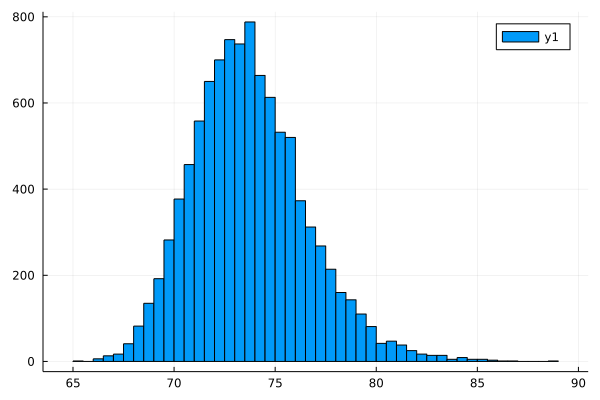

In [27]:
# crudely using the reserving basis and a 10% profit margin
profit_margin = 0.1
amount = price(policy, resbasis, profit_margin)

amount = convert(Vector{Float64}, amount)
histogram(1:nsims, amount)